In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv(f'salary.txt', sep='\s+')

In [3]:
df

,case,id,sex,deg,yrdeg,field,startyr,year,rank,admin,salary
0,1,1,F,Other,92,Other,95,95,Assist,0,6684.0
1,2,2,M,Other,91,Other,94,94,Assist,0,4743.0
2,3,2,M,Other,91,Other,94,95,Assist,0,4881.0
3,4,4,M,PhD,96,Other,95,95,Assist,0,4231.0
4,5,6,M,PhD,66,Other,91,91,Full,1,11182.0
...,...,...,...,...,...,...,...,...,...,...,...
19787,19788,1770,M,Other,51,Other,64,91,Full,0,5318.0
19788,19789,1770,M,Other,51,Other,64,92,Full,0,5472.0
19789,19790,1770,M,Other,51,Other,64,93,Full,0,5551.0
19790,19791,1770,M,Other,51,Other,64,94,Full,0,5551.0


In [4]:
# total number of unique individuals in study
unique_ids = np.unique(df.id.values)
len(unique_ids)

1597

In [5]:
# Has sex bias existed in granting promotions from Associate to full Professor?

In [6]:
useable_ids = []
for id_ in unique_ids:
    
    df_single = df[df.id == id_]
    
    if ('Assoc' in df_single['rank'].values) and (df_single['rank'].values[-1] == 'Full'):
        useable_ids.append(int(id_))

In [7]:
# number of actual samples (unique individuals) who were associate and got to full prof rank
len(useable_ids)

547

In [8]:
len(useable_ids) / len(unique_ids)

0.3425172197871008

----------

In [141]:
df['promoted'] = 0
df.loc[df.id.isin(useable_ids), 'promoted'] = 1

df['sex_ord'] = (df.sex.values == 'M').astype(np.uint8)
df['deg_ord'] = pd.Categorical(df['deg'], categories=df['deg'].unique().tolist(), ordered=True).codes
df['field_ord'] = pd.Categorical(df['field'], categories=df['field'].unique().tolist(), ordered=True).codes

In [142]:
df['deg'].unique().tolist()

['Other', 'PhD', 'Prof']

In [143]:
df['field'].unique().tolist()

['Other', 'Arts', 'Prof']

In [144]:
df_piv = pd.pivot_table(df, 
                       values=['startyr', 'sex_ord', 'yrdeg', 'deg_ord', 'field_ord',
                               'promoted'],
                       index=['id'],
                       aggfunc="min")

In [228]:
# center larger terms
df_piv['yrdeg_centered'] = df_piv['yrdeg'] - np.mean(df_piv['yrdeg'])
df_piv['startyr_centered'] = df_piv['startyr'] - np.mean(df_piv['startyr'])

# interaction terms
df_piv['inter_sex_yrdeg'] = df_piv['sex_ord'] * df_piv['yrdeg_centered']
df_piv['inter_sex_startyr'] = df_piv['sex_ord'] * df_piv['startyr_centered']

In [229]:
df_piv.head()

,deg_ord,field_ord,promoted,sex_ord,startyr,yrdeg,yrdeg_centered,startyr_centered,inter_sex_yrdeg,inter_sex_startyr
id,,,,,,,,,,
1,0,0,0,0,95,92,15.905448,13.884158,0.000000,0.000000
2,0,0,0,1,94,91,14.905448,12.884158,14.905448,12.884158
4,1,0,0,1,95,96,19.905448,13.884158,19.905448,13.884158
6,1,0,0,1,91,66,-10.094552,9.884158,-10.094552,9.884158
7,1,0,0,1,71,70,-6.094552,-10.115842,-6.094552,-10.115842


In [244]:
model = sm.Logit(df_piv.promoted, df_piv[['deg_ord',
                                          'field_ord',
                                          'sex_ord', 
                                          # 'yrdeg', 'startyr',
                                          'startyr_centered', 'yrdeg_centered',
                                          'inter_sex_startyr', 'inter_sex_yrdeg']])

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [245]:
res = model.fit(start_params=None,
            method='newton',
            maxiter=50,
            full_output=1,
            disp=1,
            callback=None
         )

Optimization terminated successfully.
         Current function value: 0.568453
         Iterations 6


In [246]:
res.converged

True

In [247]:
res.bse

deg_ord              0.112641
sex_ord              0.127718
startyr_centered     0.030196
yrdeg_centered       0.027614
inter_sex_startyr    0.032140
inter_sex_yrdeg      0.029829
dtype: float64

(array([  2.,  13.,  43.,  88., 189., 203., 169., 222., 306., 362.]),
 array([-33.1158422, -28.4158422, -23.7158422, -19.0158422, -14.3158422,
         -9.6158422,  -4.9158422,  -0.2158422,   4.4841578,   9.1841578,
         13.8841578]),
 <BarContainer object of 10 artists>)

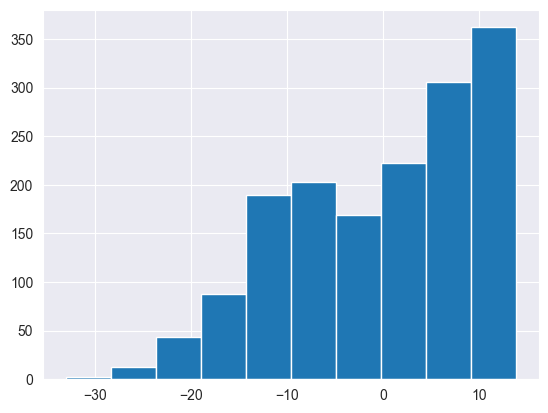

In [255]:
plt.hist(df_piv['startyr_centered'].values)

In [248]:
# plt.hist(res.fittedvalues.values);

In [249]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               promoted   No. Observations:                 1597
Model:                          Logit   Df Residuals:                     1591
Method:                           MLE   Df Model:                            5
Date:                Wed, 12 Mar 2025   Pseudo R-squ.:                  0.1155
Time:                        17:56:34   Log-Likelihood:                -907.82
converged:                       True   LL-Null:                       -1026.4
Covariance Type:            nonrobust   LLR p-value:                 3.186e-49
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
deg_ord              -0.4380      0.113     -3.888      0.000      -0.659      -0.217
sex_ord              -0.1731      0.128     -1.355      0.175      -0.423       0.077
startyr_centered     -0.1722      0.030     -5.702      0.000      -0.231      -0.113
yrdeg_centered       -0.0214      0.028     -0.773      0.439      -0.075       0.033
inter_sex_startyr     0.0855      0.032      2.661      0.008       0.023       0.149
inter_sex_yrdeg       0.0640      0.030      2.145      0.032       0.006       0.122
=====================================================================================
"""

In [236]:
# inter_sex_startyr: 0.0857	(positive and significant) it suggests that the effect of startyr (starting year) on promotion 
    # is stronger for men than for women 
    # (e.g., men hired more recently have a higher promotion rate than women hired in the same years).

# inter_sex_yrdeg: 0.0639 (positive and significant) it suggests that the effect of yeardeg (year degree was obtained) on promotion
    # is stronger for men than for women 
    # (e.g. men who have obtained degrees more recently have a higher chance of promotion compared to females with more recent degree)

In [250]:
from sklearn.metrics import roc_curve, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

In [251]:
y_pred = model.predict(res.params, which='mean')

In [252]:
np.unique(df_piv.promoted.values, return_counts=True)

(array([0, 1]), array([1050,  547]))

In [242]:
def plot_roc_pr(yt, yp):
    plt.figure(figsize=(20,7))
    
    fpr, tpr, ts = roc_curve(yt, yp)
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'ROC AUC: {roc_auc:0.4f}')
    plt.plot([0,1], [0,1], ls='--', color='orange', label='random')
    plt.legend()
    
    precision, recall, thresholds = precision_recall_curve(yt, yp)
    pr_auc = auc(recall, precision)
    
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f'PR AUC: {pr_auc:0.4f}')
    plt.axhline(547/(547+1050), ls='--', color='orange', label='random')
    plt.legend()
    plt.show()

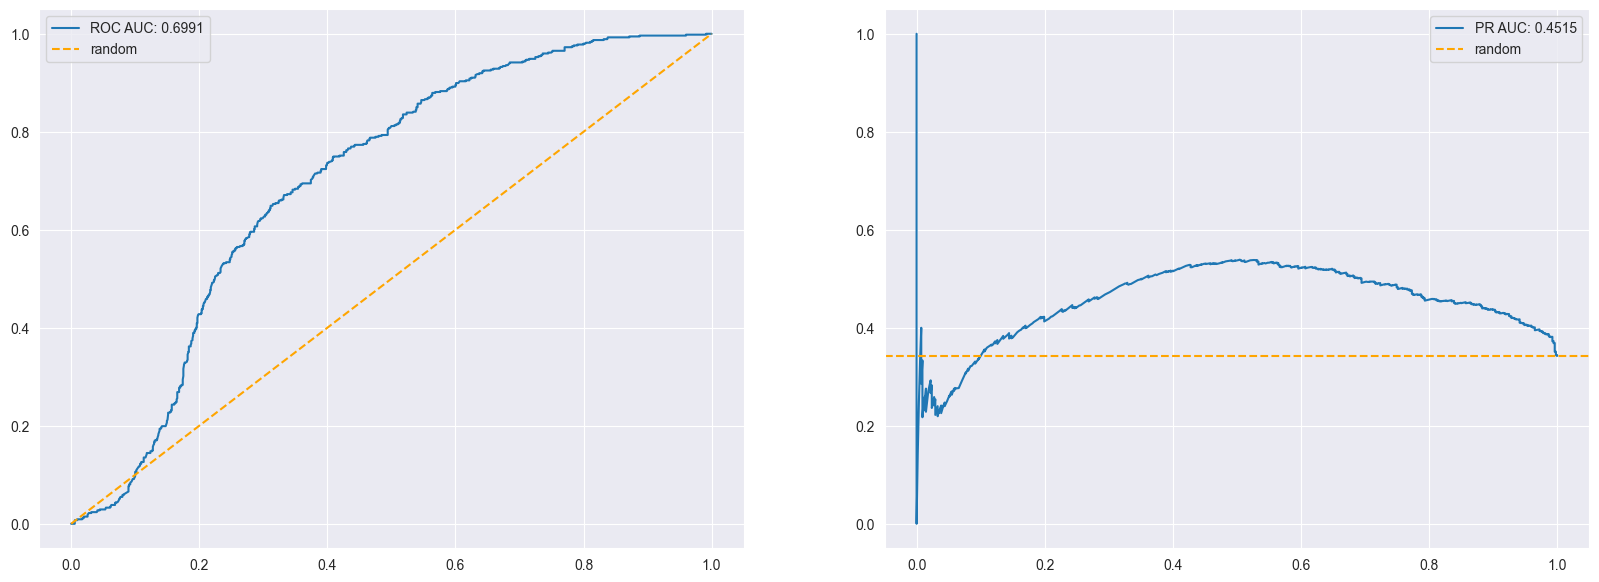

In [227]:
# with no centering for interaction terms
plot_roc_pr(df_piv.promoted, y_pred)

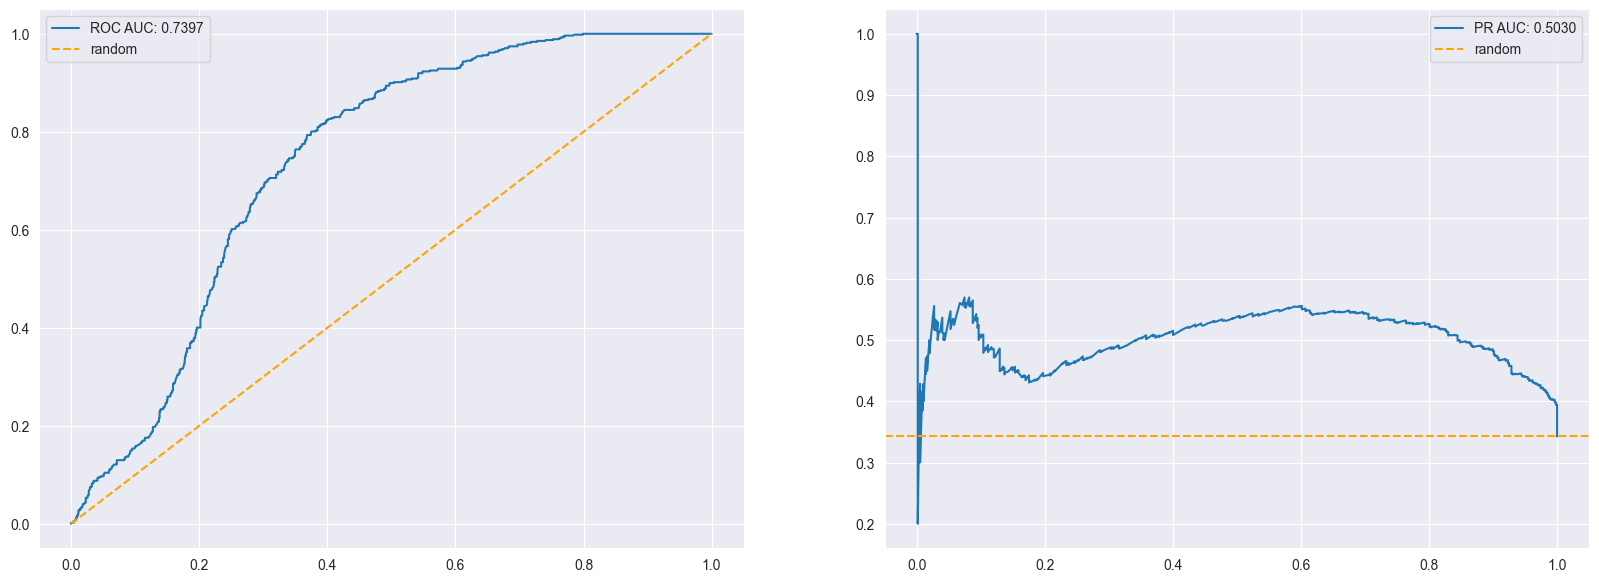

In [243]:
# with centering for interaction terms
plot_roc_pr(df_piv.promoted, y_pred)